In [1]:
# !pip install func_timeout
# !pip install FunctionTimedOut

In [2]:
from threading import Thread
import functools

#V= np.array([[-4, 3, 1, -3, 2], [1, 4, -4, -2, -3], [-1,  0,  2, -2,  1], [ 4,  0, -3, -2, -4], [ 2, -1,  0, -2,  1], [-1,  2,  0, -2,  1], [ 3, -3,  4,  1, -2]])

def timeout(timeout):
    def deco(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            res = [Exception('function [%s] timeout [%s seconds] exceeded!' % (func.__name__, timeout))]
            def newFunc():
                try:
                    res[0] = func(*args, **kwargs)
                except Exception as e:
                    res[0] = e
            t = Thread(target=newFunc)
            t.daemon = True
            try:
                t.start()
                t.join(timeout)
            except Exception as je:
                print ('error starting thread')
                raise je
            ret = res[0]
            if isinstance(ret, BaseException):
                raise ret
            return ret
        return wrapper
    return deco

#func = timeout(timeout=5)(calc_fitness(V))


# func = timeout(timeout=16)(MyModule.MyFunc)
# try:
#     func()
# except:
#     pass #handle errors here

In [3]:
import numpy as np
from fractions import Fraction
import cdd
from polytope.polytope import qhull, enumerate_integral_points, ABS_TOL

In [4]:
from func_timeout import func_timeout, FunctionTimedOut

#code based on https://github.com/stephane-caron/pypoman/blob/master/pypoman/duality.py
def compute_distances(vertices: np.ndarray) -> np.ndarray:
    
    #print(vertices)
    V = np.vstack(vertices)
    t = np.ones((V.shape[0], 1))  # first column is 1 for vertices
    tV = np.hstack([t, V])
    mat = cdd.Matrix(tV, number_type="fraction")
    mat.rep_type = cdd.RepType.GENERATOR
    P = cdd.Polyhedron(mat)
    bA = np.array(P.get_inequalities())
    if bA.shape == (0,):  # bA == []
        return bA
    # the polyhedron is given by b + A x >= 0 where bA = [b|A]
    b = bA[:, 0]
    A = -np.array(bA[:, 1:])

    for i, row in enumerate(A):
        denominators = []
        has_fraction = False
        for j in row:
            if type(j) == Fraction:
                has_fraction = True
                denominators.append(j.denominator)    
        if has_fraction:
            b[i] *= np.lcm.reduce(denominators)
    return b

#from func_timeout import func_timeout, FunctionTimedOut

@timeout(60)
def calc_fitness(vertices):
    integral_points = enumerate_integral_points(qhull(vertices))
    integral_points = integral_points.transpose()
    integral_points = integral_points.astype(int)
    ip_count = len(integral_points)
    distances = compute_distances(vertices)
    result = 0
    if ip_count > 1:
        result -= 1
    for d in distances:
        result -= abs(d-1)
    return result

In [5]:




print("using ABS_TOL: {0}".format(ABS_TOL))




#reflexive
#V = np.array([[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]])
#non-reflexive
#V = np.array([[-1, -2, 2], [1, 2, -2], [-3, -2, 0], [1, 2, -3], [0, -1, 2]])

#V = np.array([[0,-2,1], [-1, 1, 0], [2, 1, -1], [0, -2, 2], [-1, 0, -3]])

#V = np.array([[0,-3,-1], [0,2,1], [-1,-3,-2], [-1,1,-2], [-1,-2,-3]])

#V= np.array([[-11, 7, 30, -15, 1], [-13, 10, -70, 1, 5], [7, -6, -25, 0, 9], [-13, 1, -15, 13, -11], [-14, 5, 13, 1, -2], [-2, 2, -10, 1, -3], [7, -8, 2, -7, 10]])

V = np.array([[-2,  3,  1, -3,  0],
       [ 1, -2, -1,  2,  0],
       [ 4, -4,  1,  2, -2],
       [ 1,  2,  3,  0, -1],
       [-3,  3, -1, -2,  2],
       [ 1,  2,  3, -3, -1],
       [-2, -1, -3,  0,  2]])

# integral_points = enumerate_integral_points(qhull(V))
# integral_points = integral_points.transpose()
# integral_points = integral_points.astype(int)
# print("integral_points: {0}".format(integral_points))
# print("distance vector: {0}".format(compute_distances(V)))
print("fitness: {0}".format(calc_fitness(V)))


using ABS_TOL: -1e-07
fitness: 0


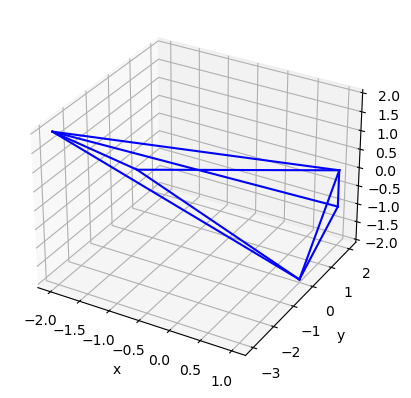

In [11]:
import matplotlib.pyplot as plt

V = np.array([[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]])
#V = np.array([[-1, -2, 2], [1, 2, -2], [-3, -2, 0], [1, 2, -3], [0, -1, 2]])
#V = np.array([[-1,-1,-1], [1,-1,-1], [1,1,-1], [-1,1,-1], [-1,1,1], [1,1,1], [1,-1,1], [-1,-1,1]])


# to get the convex hull with cdd, one has to prepend a column of ones
num_verts = V.shape[0]
vertices = np.hstack((np.ones((num_verts,1)), V))

# construct the polyhedron
mat = cdd.Matrix(vertices, linear=False, number_type="float") 
mat.rep_type = cdd.RepType.GENERATOR
poly = cdd.Polyhedron(mat)

# get the adjacent vertices of each vertex
adjacencies = [list(x) for x in poly.get_input_adjacency()]

# store the edges in a matrix (giving the indices of the points)
edges = [None]*(num_verts-1)
for i,indices in enumerate(adjacencies[:-1]):
    indices = list(filter(lambda x: x>i, indices))
    l = len(indices)
    col1 = np.full((l, 1), i)
    indices = np.reshape(indices, (l, 1))
    edges[i] = np.hstack((col1, indices))
Edges = np.vstack(tuple(edges))

num_edges = Edges.shape[0]

# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

start = V[Edges[:,0]]
end = V[Edges[:,1]]

for i in range(num_edges):
    ax.plot(
        [start[i,0], end[i,0]], 
        [start[i,1], end[i,1]], 
        [start[i,2], end[i,2]],
        "blue"
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [12]:
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

#V = np.array([[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]])
#V = np.array([[-1, -2, 2], [1, 2, -2], [-3, -2, 0], [1, 2, -3], [0, -1, 2]])
V = np.array([[-1,-1,-1], [1,-1,-1], [1,1,-1], [-1,1,-1], [-1,1,1], [1,1,1], [1,-1,1], [-1,-1,1]])

hull = ConvexHull(V)
hull_points = hull.points
hull_simplices = hull.simplices

x = hull_points[:, 0]
y = hull_points[:, 1]
z = hull_points[:, 2]

i = hull_simplices[:, 0]
j = hull_simplices[:, 1]
k = hull_simplices[:, 2]

mesh3d  = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1.0, flatshading=True, color="#ce6a6b")
layout = go.Layout(width=600, height=600, title_text='polytope', title_x=0.5)
fig = go.Figure(data=[mesh3d], layout=layout)
fig.layout.scene.update(xaxis_showticklabels=False, xaxis_ticks='', xaxis_title='',
                        yaxis_showticklabels=False, yaxis_ticks='',yaxis_title='',
                        zaxis_showticklabels=False, zaxis_ticks='', zaxis_title='')
fig.data[0].update(lighting=dict(ambient=0.5, diffuse=1, fresnel=4, specular=0.5, roughness=0.5))

fig.show()

In [13]:
lis = [[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]]
print(lis)
lis.sort(key=lambda x: int(x[0]))
print(lis)

#print(sorted(lis, key=lambda x: x[0]))

a = np.array([[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]])
b = np.array([[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]])

a.tolist()
#a.sort(key=lambda x: int(x[0]))
print(a)
#b.flatten().tolist()

print(repr(a))


#print(b)
#print(np.sort(a))

print(sorted(a, key=lambda x: x[0]))
print("----------------")

c = sorted(a, key=lambda x: x[0])
print(c)
c = np.array2string(a, separator=',')
#print(type(c))

print(c)


# abcde = {}
# abcde[c] = a
# print(abcde)

# if (a==b).all():
#     print(True)

[[1, 0, -2], [-2, -3, 2], [-1, -2, 1], [1, 2, -1], [1, 2, 0]]
[[-2, -3, 2], [-1, -2, 1], [1, 0, -2], [1, 2, -1], [1, 2, 0]]
[[ 1  0 -2]
 [-2 -3  2]
 [-1 -2  1]
 [ 1  2 -1]
 [ 1  2  0]]
array([[ 1,  0, -2],
       [-2, -3,  2],
       [-1, -2,  1],
       [ 1,  2, -1],
       [ 1,  2,  0]])
[array([-2, -3,  2]), array([-1, -2,  1]), array([ 1,  0, -2]), array([ 1,  2, -1]), array([1, 2, 0])]
----------------
[array([-2, -3,  2]), array([-1, -2,  1]), array([ 1,  0, -2]), array([ 1,  2, -1]), array([1, 2, 0])]
[[ 1, 0,-2],
 [-2,-3, 2],
 [-1,-2, 1],
 [ 1, 2,-1],
 [ 1, 2, 0]]


In [14]:
np.array2string(b).replace("\n", ",")

'[[ 1  0 -2], [-2 -3  2], [-1 -2  1], [ 1  2 -1], [ 1  2  0]]'

In [15]:
[[-2, 3, 1, -3, 0], [1,-2,-1, 2, 0], [ 4,-4, 1, 2,-2], [ 1,2,3,0,-1], [-3,3,-1,-2,2], [ 1,2,3,-3,-1], [-2,-1,-3,0,2]]

[[-2, 3, 1, -3, 0],
 [1, -2, -1, 2, 0],
 [4, -4, 1, 2, -2],
 [1, 2, 3, 0, -1],
 [-3, 3, -1, -2, 2],
 [1, 2, 3, -3, -1],
 [-2, -1, -3, 0, 2]]

In [1]:
from multiprocessing import Pool
import subprocess
import sys
import csv
import timeit


def task_runner(input):
    print(input)
    return input


parents_pool = list(["eins", "zwei", "drei"])
num_processes = 6
#print(parents_pool)
with Pool(num_processes) as p:
    print("in pool")
    result = p.map(task_runner, parents_pool)

in pool
